In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:16, 1471.49it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [6]:
data = pd.DataFrame(responses)

In [7]:
data.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


# 1. Посчитайте количество отзывов в разных городах и на разные банки

In [8]:
data['bank_name'].value_counts()

Сбербанк России                                         26327
Альфа-Банк                                              10224
ВТБ 24                                                   8185
Русский Стандарт                                         7943
Хоум Кредит Банк                                         7549
Тинькофф Банк                                            5387
Национальный Банк «Траст»                                4607
Ренессанс Кредит                                         3849
Связной Банк                                             3775
ОТП Банк                                                 3237
Восточный Экспресс Банк                                  3138
Райффайзенбанк                                           3057
Московский Кредитный Банк                                2944
Ситибанк                                                 2848
Авангард                                                 2733
Промсвязьбанк                                            2586
ЮниКреди

### Наименования банков выглядят нормально.

In [9]:
data['city'].value_counts()

г. Москва                                                       55354
г. Санкт-Петербург                                              14342
г. Екатеринбург                                                  2337
г. Новосибирск                                                   2300
г. Нижний Новгород                                               1976
г. Ростов-на-Дону                                                1891
г. Самара                                                        1731
г. Челябинск                                                     1507
г. Казань                                                        1440
г. Краснодар                                                     1262
г. Уфа                                                           1246
г. Красноярск                                                    1236
г. москва                                                        1217
г. Воронеж                                                       1210
г. Пермь            

In [10]:
data.groupby('city').size().loc[lambda x: x == 3].sort_values()

city
г. Samara                                   3
г. Ростов-на Дону                           3
г. Ростов-на-Дону (Краснодар)               3
г. Рыбинск (Ярославская обл.)               3
г. Рязань (Москва)                          3
г. Санкт-Перербург                          3
г. Санкт-Петебрург                          3
г. Санкт-Петербрг                           3
г. Санкт-Петербугр                          3
г. Санкт-Петербург (Санкт-Петербург)        3
г. Санкт-Петербург - Москва                 3
г. Санкт-Петербург, Москва                  3
г. Санкт-Петербург, г. Пушкин               3
г. Санкт-Птербург                           3
г. Санкт-Птеребург                          3
г. Саратов (Саратовская область)            3
г. Сафоново (Смоленская область)            3
г. Северодвинск (Архангельская обл.)        3
г. Североуральск. пос Калья                 3
г. Сегежа                                   3
г. Селятино                                 3
г. Семилуки                  

### Наименования городов в больше части выглядят нормально, но есть и мусорные названия.

In [11]:
grouped = data[['bank_name', 'city']].groupby(['bank_name', 'city'])['bank_name'].agg('count').to_frame('count')['count'].groupby(level=0, group_keys=False)

In [12]:
grouped.nlargest(5)

bank_name                city                            
2Т Банк                  г. Москва                            359
                         г. Санкт-Петербург                   163
                         г. Краснодар                          11
                         г. Новороссийск                       10
                         г. Нижний Новгород                     7
АБ Финанс                г. Москва                              7
                         г. Тюмень                              2
                         г. Воронеж                             1
                         г. Мытищи                              1
                         г. Нижний Новгород                     1
АББ                      г. Москва                              1
                         г. Санкт-Петербург                     1
АМБ Банк                 г. Москва                              1
АМТ Банк                 г. Москва                             73
                  

# 2. Постройте гистограмы длин слов в символах и в словах

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


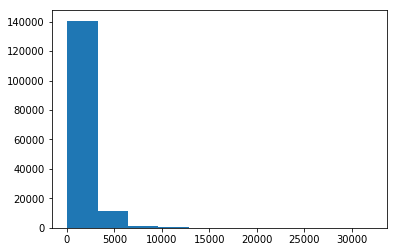

In [13]:
length = data['text'].apply(len).tolist()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


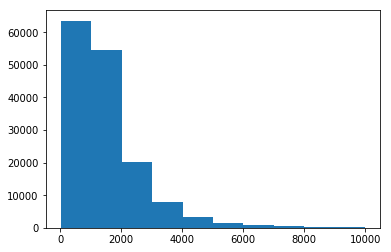

In [14]:
length = [x for x in length if x < 10000]
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


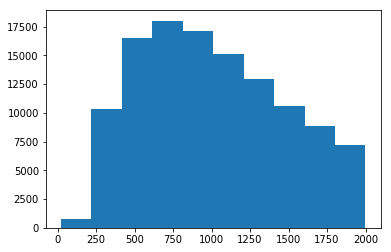

In [15]:
length = [x for x in length if x < 2000]
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

### Основная часть длин текстов находится в пределах 2000 символов.

In [16]:
from nltk.tokenize import toktok
toktok = toktok.ToktokTokenizer()

In [17]:
def word_count(str):
    return len(toktok.tokenize(str, return_str=False))

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


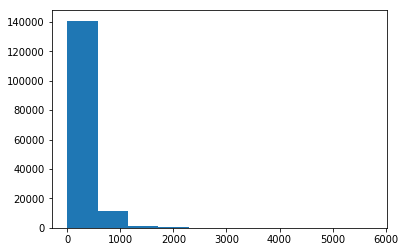

In [18]:
length = data['text'].apply(word_count).tolist()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


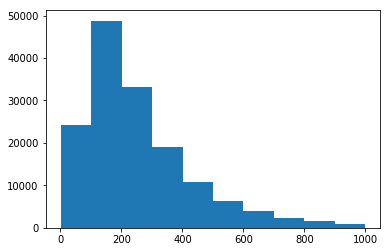

In [19]:
length = [x for x in length if x < 1000]
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

/home/myxrome/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


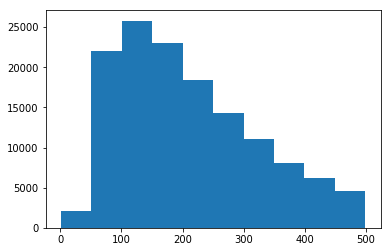

In [20]:
length = [x for x in length if x < 500]
fig, ax = plt.subplots()
n, bins, patches = ax.hist(length)
fig.show()

### Основная часть текстов состоит менее чем из 1000 слов.

# 3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных


In [21]:
prog = regex.compile('[А-Яа-я]+')
def extract_tokens(str):
    return [' '.join(prog.findall(x.lower())) for x in toktok.tokenize(str, return_str=False) if prog.findall(x)]

In [22]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'очень', 'г', 'именно', 'просто', 'руб', 'который', 'нужно', 'тк', 'хотя', 'мои', 'моей', 'также', 'сразу', 'несколько', 'вообще', 'которые', 'всё', 'мной', 'моего', 'никто', 'свои', 'снова', 'именно']

In [23]:
def clean_tokens(tokens):
    return [x for x in tokens if x not in mystopwords]

In [24]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="ru")

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
from collections import Counter

all_words_cnt = Counter()
good_words_cnt = Counter()
lemmas_cnt = Counter()
nouns_cnt = Counter()
n_types = []
n_tokens = []
all_lemmas = []

for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = extract_tokens(row['text'])
    all_words_cnt.update(tokens)

    good_tokens = clean_tokens(tokens)
    good_words_cnt.update(good_tokens)
    
    forms = predictor.predict(good_tokens)
    lemmas = []
    nouns = []
    for form in forms:
        lemmas.append(form.normal_form)
        if form.pos == 'NOUN':
            nouns.append(form.normal_form)
    all_lemmas.append(lemmas)
    lemmas_cnt.update(lemmas)
    nouns_cnt.update(nouns)
    
    n_types.append(len(lemmas_cnt))
    n_tokens.append(sum(lemmas_cnt.values()))

100%|██████████| 153499/153499 [7:01:07<00:00, 10.39it/s]   


In [26]:
for i in all_words_cnt.most_common(10):
    print(i)

('в', 1323379)
('и', 1055355)
('не', 854696)
('на', 704478)
('что', 621911)
('я', 576385)
('с', 455749)
('по', 365281)
('мне', 320748)
('банка', 264276)


In [27]:
for i in good_words_cnt.most_common(10):
    print(i)

('банка', 264276)
('банк', 196685)
('деньги', 130163)
('карту', 105091)
('карты', 101062)
('кредит', 80360)
('день', 76069)
('заявление', 69577)
('отделение', 66503)
('время', 65605)


In [28]:
for i in lemmas_cnt.most_common(10):
    print(i)

('банк', 536152)
('карта', 332333)
('деньга', 178486)
('день', 172328)
('кредит', 155033)
('отделение', 143688)
('сотрудник', 133740)
('клиент', 133318)
('счёт', 125119)
('сумма', 111011)


In [29]:
for i in nouns_cnt.most_common(10):
    print(i)

('банк', 536108)
('карта', 331665)
('деньга', 178376)
('день', 172319)
('кредит', 154926)
('отделение', 143525)
('сотрудник', 133734)
('клиент', 133311)
('счёт', 125113)
('сумма', 110778)


### Я извиняюсь, к блоку курса приступил с задержкой, в связи с высокой загрузкой на работе. Данная домашняя работа находится на стадии доработки. Я выполню это задание до конца, но в срок уложиться, к сожалению, не получилось.

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
